# Using `ncbi.datasets` library to download and parse virus datasets

The objective of this notebook is to use the `ncbi.datasets` python library to download and extract viral genome and annotation data.

First, let's import the python modules we'll use.  Be sure you have first installed the requirements in 'requirements.txt' into your virtual environment. 

In [1]:
import ncbi.datasets
import json
import os
import csv
import yaml
import zipfile
import pandas as pd
from pyfaidx import Fasta
from google.protobuf.json_format import ParseDict
import ncbi.datasets.v1alpha1.reports.virus_pb2 as virus_report_pb2
from collections import OrderedDict, Counter
from datetime import datetime, timezone, timedelta

We will need an api object specific to retrieving viral data. To see all the possible API instances, [visit the documentation on GitHub](https://github.com/ncbi/datasets/tree/master/client_docs/python#documentation-for-api-endpoints)". 

In [1]:
virus_api = ncbi.datasets.VirusDownloadApi(ncbi.datasets.ApiClient())

## The NCBI data report

Viral genome data downloaded using the NCBI Datasets API uses the same file hierarchy as the other assembly download objects (see [Assembly Jupyter Notebook](ncbi-datasets-assembly.ipynb) to learn more). The structured zip archive in the bdbag format contains a data report that can be traversed using the `ncbi.datasets` python library to extract metadata. 

To illustrate how one can use these files, we will download all RefSeq genomes for the coronaviridae family and extract some genome and annotation information in tabular form. 

In [1]:
## download all refseq genomes for the coronaviridate family (taxid 11118)

taxid = 11118

viral_genomes = virus_api.get_virus_dataset_stream(
    taxid, 
    refseq_only=True, 
    _preload_content=False
)

zipfn = 'ncbi_genomes.zip'
with open(zipfn, 'wb') as f:
    f.write(viral_genomes.data)

print(f'Download complete')

!unzip -v {zipfn}

Download complete
Archive:  ncbi_genomes.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
      57  Defl:N       59  -4% 06-23-2020 07:07 b0865ddc  ncbi_dataset/bagit.txt
     998  Defl:N      627  37% 06-23-2020 07:07 44e1e93f  README.md
 2493542  Defl:N   751459  70% 06-23-2020 07:07 bb874afc  ncbi_dataset/data/cds.fna
 1918833  Defl:N   535030  72% 06-23-2020 07:07 d2b5aa35  ncbi_dataset/data/genomic.fna
  894477  Defl:N   530384  41% 06-23-2020 07:07 7fbeb425  ncbi_dataset/data/protein.faa
 3900105  Defl:N  1796276  54% 06-23-2020 07:07 afec3a0d  ncbi_dataset/data/genomic.gbff
 3106681  Defl:N  1938053  38% 06-23-2020 07:07 58b889e3  ncbi_dataset/data/protein.gpff
  708377  Defl:N   442335  38% 06-23-2020 07:07 5aa80882  ncbi_dataset/data/data_report.yaml
    2398  Defl:N     1495  38% 06-23-2020 07:07 8d3e9da3  ncbi_dataset/data/virus_dataset.md
 2111508  Defl:N   913685  57% 06-23-2020 07:07 4211db1c

The contents of the bdbag archive are shown above. We will use the following function to extract data from the `data_report.yaml` file and read it into an object (named `virus_report` in this example).

In [1]:
def virus_report_for(path_to_zipfile):
    '''
    Return an object representing the data report.
    path_to_zipfile: The relative path to the zipfile containing the virus data report
    
    '''
    print(f'Extract virus data report from {path_to_zipfile}')
    with zipfile.ZipFile(path_to_zipfile, 'r') as zip:
        virus_report_as_dict = yaml.safe_load(zip.read('ncbi_dataset/data/data_report.yaml'))

    print(f'Parse into virus-report')
    virus_report = virus_report_pb2.VirusReport()
    ParseDict(virus_report_as_dict, virus_report)
    print(f'Genome count: {len(virus_report.genomes)}')
    return virus_report

In [1]:
virus_report = virus_report_for(zipfn)

Extract virus data report from ncbi_genomes.zip
Parse into virus-report
Genome count: 66


As shown below, one can easily navigate through the contents of the `virus_report` object to extract data. 

In [1]:
genome_data = []
for g in virus_report.genomes:
    genome_data.append({
        'Accession': g.accession,
        'TaxID': g.virus.tax_id,
        'VirusName': g.virus.sci_name,
        'Host': g.host.sci_name,
        'Isolate': g.isolate.name,
        'Location': g.location.geographic_location,
        'Length': g.length,
        'Genes': g.gene_count,
        'Proteins': g.protein_count,
        'MaturePeptides': g.mature_peptide_count
    })
    
df1 = pd.DataFrame(genome_data)
df1.head()

,Accession,TaxID,VirusName,Host,Isolate,Location,Length,Genes,Proteins,MaturePeptides
0,NC_001451.1,11120,Infectious bronchitis virus,,,,27608,6,10,14
1,NC_001846.1,11138,Murine hepatitis virus,,,,31357,4,5,0
2,NC_002306.3,11135,Feline infectious peritonitis virus,,79-1146,USA,29355,10,9,0
3,NC_002645.1,11137,Human coronavirus 229E,,,,27317,7,8,0
4,NC_003436.1,28295,Porcine epidemic diarrhea virus,,,,28033,6,6,13


We can now quickly generate plots using the data in the dataframe. For example, a set of histograms showing the distribution of the length of the genomes, and the number of genes, proteins and mature peptides is shown below. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0778b3c910>,
      dtype=object)

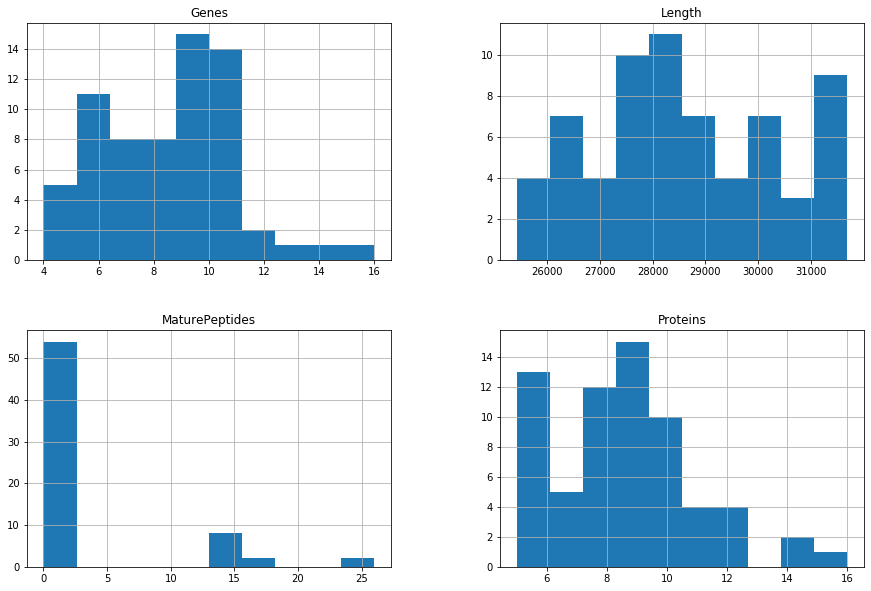

In [1]:
df1.hist(column=['Length', 'Genes', 'Proteins', 'MaturePeptides'], figsize=(15,10))

Along the same lines, data can be extracted from the `data_report.yaml` file and saved as a tab-delimited file to use in external applications like R and Excel. 

In [1]:
genome_table = [['gene_name', 'nuc_acc', 'nuc_ranges', 'prot_name', 'prot_acc', 'prot_len']]
for g in virus_report.genomes:
    annot = g.annotation
    for gene in annot.genes:
        gene_name = gene.name
        for c in gene.cds:
            ranges = []
            for r in c.nucleotide.range:
                ranges.append([r.begin, r.end])
            prot_len = c.protein.range[-1].end
            genome_table.append([gene.name, c.nucleotide.accession_version, ranges, c.name, c.protein.accession_version, prot_len])

            
tsv_file = 'virus_genome_info.tsv'
with open(tsv_file, 'wt') as f:
    tbl = csv.writer(f, delimiter = '\t', lineterminator = os.linesep)
    tbl.writerows(genome_table)

Finally, we can also use the data report to compute useful summaries, like the CDS length of each protein

In [1]:
cds_lengths = []
for g in virus_report.genomes: 
    annot = g.annotation
    for gene in annot.genes: 
        for c in gene.cds:
            cds_len = 0
            for r in c.nucleotide.range:
                cds_len += r.end - r.begin + 1
            cds_lengths.append({
                'Accession': g.accession,
                'Gene': gene.name,
                'Protein': c.name,
                'CDS_Length': cds_len
            })

In [1]:
df2 = pd.DataFrame(cds_lengths)
df2.head()

,Accession,Gene,Protein,CDS_Length
0,NC_001451.1,1ab,ORF1ab polyprotein,19890
1,NC_001451.1,1ab,ORF1a polyprotein,11856
2,NC_001451.1,2,spike protein,3489
3,NC_001451.1,3,3a protein,174
4,NC_001451.1,3,3b protein,195


## Add taxid to the FASTA header

In addition to the data report, the bdbag archive contains one or more sequence files that can be processed together. For example, we can add a different set of attributes to the FASTA header in the sequence files. For this, we will first create a map of genomic accessions to taxids and virus names using the data in `data_report.yaml` file. Then, we will use the `pyfaidx` python module to change the headers in `genomic.fna` FASTA file to include taxids.

In [1]:
taxids_by_accession = dict()

for genome in virus_report.genomes:
    taxids_by_accession[genome.accession] = (genome.virus.tax_id, genome.virus.sci_name)

In [1]:
## parse data catalog 
with zipfile.ZipFile(zipfn, 'r') as zip:
    data_catalog = json.loads(zip.read('ncbi_dataset/data/dataset_catalog.json'))

In [1]:
with zipfile.ZipFile(zipfn, 'r') as zip:
    data = zip.read('ncbi_dataset/data/genomic.fna')
    with open('genomic.fna', 'wb') as f:
        f.write(data)

with open('genomic.out.fna', 'w') as f:
    genomic_seqs = Fasta('genomic.fna')
    for g in genomic_seqs:
        (taxid, org_name) = taxids_by_accession[g.name]
        header = '>' + '|'.join([g.name, str(taxid), org_name, '\n'])
        f.write(header)
        f.write(genomic_seqs[g.name][:].seq + '\n')

## Fetch all SARS-CoV-2 genomes submitted in the past 7 days

Narrowing our focus a little, if we are interested in just SARS-CoV-2 genomes they too can be downloaded using `ncbi.datasets` library as shown below. Here, for example, we will restrict the data returned to only those genomes that were submitted in the past 7 days. 

A python datetime object is created with the desired date and provided to the api instance. 

In [1]:
## to fetch all genomes submitted in the past 7 days
t = 7
d = datetime.now(timezone.utc) - timedelta(days=t)
taxid = 2697049

cov2_genomes = virus_api.get_virus_dataset_stream(
    taxid, 
    released_since = d.isoformat(), 
    _preload_content=False)

zipfn = 'ncbi_genomes.zip'
with open(zipfn, 'wb') as f:
    f.write(cov2_genomes.data)

In [1]:
%%time
## depending on the number of genomes, this step can take a while
## it takes about 7 min for ~1600 genomes. 
cov2_report = virus_report_for(zipfn)

Extract virus data report from ncbi_genomes.zip
Parse into virus-report
Genome count: 1631
CPU times: user 6min 34s, sys: 8.95 s, total: 6min 43s
Wall time: 6min 43s


Now, we can use the information in the data report to tabulate information such as the number of genomes by collection date and georaphic location as shown below. 

In [1]:
coll_by_month = Counter()

for g in cov2_report.genomes:
    coll_date = g.isolate.collection_date
    coll_date = '/'.join(coll_date.split('-')[:2])
    coll_by_month[coll_date] += 1

print(coll_by_month)

Counter({'2020/04': 672, '2020/03': 669, '2020/05': 215, '2020/02': 45, '2020/06': 23, '2020': 5, '2020/01': 2})


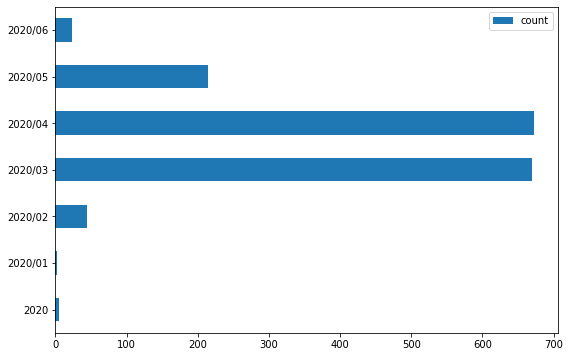

In [1]:
df = pd.DataFrame.from_dict(coll_by_month, orient='index', columns=['count']).sort_index()
df.plot(kind = 'barh', y='count', figsize=(9,6))

In [1]:
geo_by_date = []

for g in cov2_report.genomes:
    geo_by_date.append({
        'Date': g.isolate.collection_date,
        'Location': g.location.geographic_location.split(':')[0]
    })

df3 = pd.DataFrame(geo_by_month)
df3.head()

,Date,Location
0,2020-04-12,Italy
1,2020-01-23,China
2,2020-03,Hong Kong
3,2020-04-22,USA
4,2020-04-09,USA


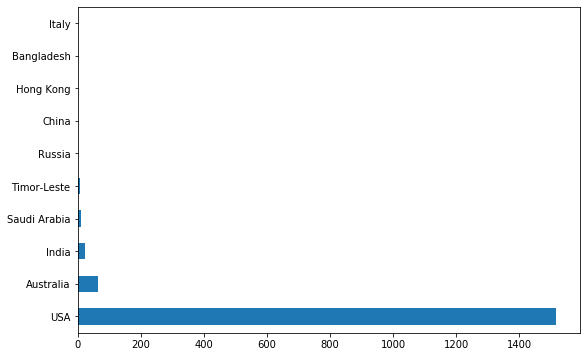

In [1]:
pd.value_counts(df3['Location']).plot.barh(figsize=(9,6))